<a href="https://colab.research.google.com/github/VrindaBajaj20/ai-attack-snow3g-nea1/blob/main/experiments/meta_future_fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Flatten, GlobalAveragePooling1D, Add, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from google.colab import files

In [2]:
print("Please upload the CSV file.")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

required_columns = ["COUNT", "Direction", "Bearer ID", "LENGTH", "KEY"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

Please upload the CSV file.


Saving snow3g_keystream_output.csv to snow3g_keystream_output.csv


In [3]:
# Validate required columns
required_columns = ["KEY", "Direction", "LENGTH", "COUNT", "Bearer ID", "Keystream_hex"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

In [4]:
# --- Step 3: Hex to bits conversion ---
def hex_to_bits(hex_str):
    # Sometimes your column may have float format; convert to str first
    hex_str = str(hex_str).split('E')[0]  # remove scientific notation if present
    return np.array([int(b) for b in bin(int(hex_str, 16))[2:].zfill(128)])

# Apply conversion to columns
df['Keystream_bits'] = df['Keystream_hex'].apply(hex_to_bits)
df['Key_bits'] = df['KEY'].apply(hex_to_bits)

X = np.stack(df['Keystream_bits'].values).astype(np.float32)
y = np.stack(df['Key_bits'].values).astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# === BASE MODELS ===

# 1️⃣ Random Forest
rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train)
rf_pred_train = rf.predict_proba(X_train)
rf_pred_test = rf.predict_proba(X_test)
rf_train_meta = np.hstack([p[:,1].reshape(-1,1) for p in rf_pred_train])
rf_test_meta = np.hstack([p[:,1].reshape(-1,1) for p in rf_pred_test])

# 2️⃣ XGBoost
xgb_models = [XGBClassifier(eval_metric='logloss') for _ in range(128)]
for i in range(128):
    xgb_models[i].fit(X_train, y_train[:, i])
xgb_train_meta = np.column_stack([model.predict_proba(X_train)[:,1] for model in xgb_models])
xgb_test_meta  = np.column_stack([model.predict_proba(X_test)[:,1] for model in xgb_models])

# 3️⃣ CNN
X_train_cnn = X_train.reshape(-1, 128, 1)
X_test_cnn = X_test.reshape(-1, 128, 1)
cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(128,1)),
    Conv1D(128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=128, validation_data=(X_test_cnn, y_test), verbose=0)
cnn_train_meta = cnn.predict(X_train_cnn)
cnn_test_meta  = cnn.predict(X_test_cnn)

# 4️⃣ MLP
mlp = Sequential([
    Dense(256, activation='relu', input_shape=(128,)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='sigmoid')
])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), verbose=0)
mlp_train_meta = mlp.predict(X_train)
mlp_test_meta  = mlp.predict(X_test)

# === META FEATURE FUSION ===
# Concatenate predictions from all base models
train_meta_features = np.concatenate([rf_train_meta, xgb_train_meta, cnn_train_meta, mlp_train_meta], axis=1)
test_meta_features  = np.concatenate([rf_test_meta, xgb_test_meta, cnn_test_meta, mlp_test_meta], axis=1)

print("Meta feature shapes:", train_meta_features.shape, test_meta_features.shape)

# === META LEARNER ===
meta_model = MultiOutputClassifier(LogisticRegression(max_iter=500))
meta_model.fit(train_meta_features, y_train)

y_pred_meta = meta_model.predict(test_meta_features)
bitwise_acc_meta = np.mean(y_pred_meta == y_test, axis=0)
print(f"Meta-Fusion Bitwise Accuracy: {np.mean(bitwise_acc_meta)*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Meta feature shapes: (80, 512) (20, 512)
Meta-Fusion Bitwise Accuracy: 50.47%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


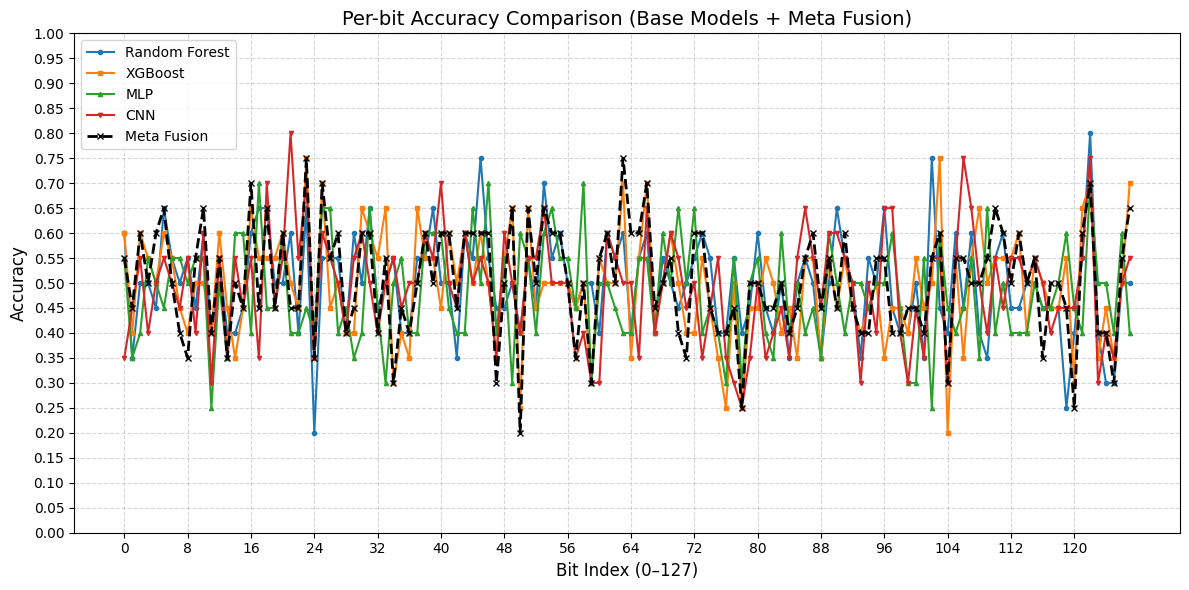

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute bitwise predictions for all base models ---

# Random Forest
y_pred_rf = rf.predict(X_test)
bitwise_acc_rf = np.mean(y_pred_rf == y_test, axis=0)

# XGBoost
y_pred_xgb = np.column_stack([model.predict(X_test) for model in xgb_models])
bitwise_acc_xgb = np.mean(y_pred_xgb == y_test, axis=0)

# MLP
y_pred_mlp = (mlp.predict(X_test) > 0.5).astype(int)
bitwise_acc_mlp = np.mean(y_pred_mlp == y_test, axis=0)

# CNN
X_test_cnn = X_test.reshape(-1, 128, 1)
y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int)
bitwise_acc_cnn = np.mean(y_pred_cnn == y_test, axis=0)

# Meta Fusion
bitwise_acc_meta = np.mean(y_pred_meta == y_test, axis=0)

# --- Plot per-bit accuracy ---
plt.figure(figsize=(12,6))
plt.plot(range(128), bitwise_acc_rf,  label="Random Forest", linewidth=1.5, marker='o', markersize=3)
plt.plot(range(128), bitwise_acc_xgb, label="XGBoost",       linewidth=1.5, marker='s', markersize=3)
plt.plot(range(128), bitwise_acc_mlp, label="MLP",           linewidth=1.5, marker='^', markersize=3)
plt.plot(range(128), bitwise_acc_cnn, label="CNN",           linewidth=1.5, marker='v', markersize=3)
plt.plot(range(128), bitwise_acc_meta,label="Meta Fusion",  linewidth=2.0, color='black', linestyle='--', marker='x', markersize=4)

plt.title("Per-bit Accuracy Comparison (Base Models + Meta Fusion)", fontsize=14)
plt.xlabel("Bit Index (0–127)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(range(0, 128, 8))           # Show every 8th bit for clarity
plt.yticks(np.arange(0, 1.05, 0.05))   # Accuracy from 0 to 1
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
